In [30]:
import cv2
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import os

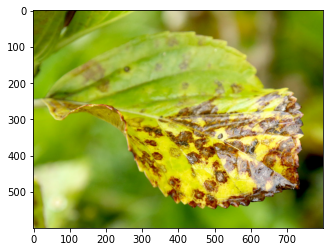

In [31]:
img1 = cv2.imread('Ferrugem.jpg')  
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

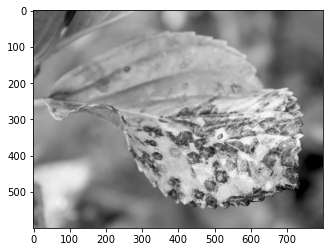

In [32]:
plt.imshow(cv2.cvtColor(gray1, cv2.COLOR_BGR2RGB))

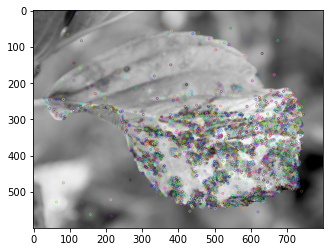

In [33]:
#keypoints
sift = cv2.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None)

img_1 = cv2.drawKeypoints(gray1,keypoints_1,img1)
plt.imshow(img_1)

### Descritores

In [34]:
descriptors_1

array([[  0.,   0.,   0., ...,   0.,   0.,   7.],
       [  1.,   1.,   3., ...,  25.,   8.,   7.],
       [ 57., 142.,  26., ...,   1.,   1.,   0.],
       ...,
       [  0.,  17.,  14., ...,   1.,   1.,   2.],
       [  4.,  17.,   2., ...,  28.,  18.,   2.],
       [  0.,   2.,   4., ...,   0.,   0.,   3.]], dtype=float32)

In [35]:
len(descriptors_1)

2214

In [36]:
len(keypoints_1)

2214

In [37]:
# Para várias imagens


# Diretório de imagens de treinamento de três classes
path={};
classes=['potato','tomato', 'cotton'];  

for x in range(len(classes)):
    ##Diretório em que se encontram as imagens##
    path[x] = os.path.abspath(os.getcwd()) + '/treinamento/%s/' %(classes[x])



In [38]:
##...initializing parameters...##
I1 = 0            # starting index of training images
I2 = 3           # end index of training images
no_img = I2 - I1    # no. of images 
clusters = 50     # no. of clusters in k-means

In [39]:
# Function to extract sift features from images of given class and concatenate them into single matrix
def sift_descriptor(Path, I1, I2):
    des_train = None
    size = None
    listing = sorted(os.listdir(Path))
    
    for image in listing[I1 : I2]:
        im = cv2.imread(Path + image)
        # finding SIFT key points and descriptors
        sift = cv2.SIFT_create()
        kp_train, des1_train = sift.detectAndCompute(im, None)
        size1 = np.shape(des1_train)
        
        if des_train is None:
            des_train = des1_train
            size = np.array([size1])
        else:
            des_train = np.concatenate((des_train, des1_train), axis = 0)
            size = np.concatenate((size, np.array([size1])), axis = 0)
              
    return des_train, size[:, 0]

In [40]:
# Function to create histogram representation of images after K-means clustering over all the SIFT features of all classes.
def create_hist(codewords, clusters, size_class, sum_features, classidx):
    idx = np.concatenate((np.array([0]), size_class))
    range1 = np.sum(sum_features[0 : classidx])
    range2 = range1 + sum_features[classidx]
    codewords_temp = codewords[range1 : range2]
    R1 = np.shape(idx)
    hist = None
    
    for i in range(0, R1[0] - 1):
        range1 = np.sum(idx[0 : i + 1])
        range2 = range1 + idx[i + 1]
        hist_temp, bin_edges = np.histogram(codewords_temp[range1 : range2], clusters)
        
        if hist is None:
             hist = hist_temp
        else:   
             hist = np.vstack((hist, hist_temp))
            
    return hist


In [41]:
# Function to encode the given test image into histogram feature.
def create_testfeature(Path, I3, centers, clusters):
    listing = sorted(os.listdir(Path))
    test_img = cv2.imread(Path + listing[I3])
    sift = cv2.SIFT_create()
    kp_train, dest1_train = sift.detectAndCompute(test_img, None)
    no_descr = np.shape(dest1_train)
    dist = np.zeros((no_descr[0], clusters))
    Min = np.zeros(no_descr[0])
    
    for i in range(0,no_descr[0]):
        for j in range(0,clusters):      
            a = dest1_train[i, :]
            b = centers[j, :]
            dist[i, j] = np.linalg.norm(a - b)
            
        Min[i] = np.argmin(dist[i, :])
        
    Min1 = Min.astype(np.float32)
    hist_test, bin_edges = np.histogram(Min1, clusters) 
    
    return hist_test.astype(float32)  

### Executando as funções

In [42]:
descr_class = {};
size_class = {};
addi={};

In [43]:
# Extract SIFT Features of images from all class and concatenate into same Matrix
for x in range(len(classes)):
        descr_class[x], size_class[x] = sift_descriptor(path[x], I1, I2)
        addi[x] = np.sum(size_class[x])

In [44]:
descriptors = np.concatenate((descr_class[0], descr_class[1], descr_class[2]), axis = 0)
sum_features = np.hstack(([0], addi[0], addi[1], addi[2]))

In [45]:
 #... performing k-means clustering on the descriptors ...#

# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Set flags (Just to avoid line break in the code)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, codewords, centers = cv2.kmeans(descriptors, clusters, None, criteria, 10, flags)

In [46]:
#... create histogram of codewords for every class
Hist_class={}

for x in range(len(classes)):
    Hist_class[x] = create_hist(codewords, clusters, size_class[x], sum_features, x + 1)

In [47]:
 #... concatenate histograms of training images to feed into the classifier
trainData = np.concatenate((Hist_class[0] ,Hist_class[1], Hist_class[2]), axis = 0)
traindata = trainData.astype(np.float32)

In [48]:
#... creating labels vector for training images
k = np.arange(3)
train_labels1 = np.repeat(k, no_img)[:, np.newaxis]
train_labels = train_labels1.astype(np.float32)

In [49]:
traindata

array([[ 13.,   2.,   3.,   3.,   1.,   0.,   5.,   2.,   7.,   4.,  14.,
          5.,   3.,   2.,   2.,   0.,   3.,   1.,   3.,  13.,   8.,  10.,
          3.,   2.,  10.,  11.,   3.,   2.,   1.,   7.,  13.,   4.,  10.,
          0.,   3.,   1.,   5.,   7.,   7.,   4.,   1.,   5.,   3.,   6.,
         14.,   1.,  10.,   6.,  12.,  33.],
       [  6.,  10.,   2.,   4.,   7.,   4.,   3.,   6.,   5.,   5.,   6.,
          1.,   6.,   9.,   4.,   0.,   4.,   3.,  15.,   4.,  17.,   2.,
          7.,   2.,   5.,   2.,  17.,   2.,   7.,   7.,  12.,   9.,  10.,
          8.,  11.,   3.,   1.,   3.,  14.,   5.,  10.,   0.,   2.,   7.,
          9.,  12.,   8.,   3.,   9.,  18.],
       [ 11.,   1.,   7.,   3.,   5.,   2.,   5.,   2.,   1.,   3.,  26.,
          3.,   1.,   7.,   2.,   0.,   4.,   1.,   7.,  24.,  37.,  13.,
          3.,   6.,  11.,   4.,  13.,   3.,   7.,   5.,  12.,  11.,  20.,
          6.,  11.,   1.,   9.,   4.,   7.,  21.,   4.,   4.,   1.,   1.,
          5.,   2.,  1

### Exemplo retirado de https://github.com/RUSidhika/SIFT-BOW/blob/master/Sift_Bow.py. Veja como foi criada a parte de treinamento. 

In [50]:
#Salvando para csv

import pandas as pd 
import numpy as np 
arr = traindata
print(arr) 



[[ 13.   2.   3.   3.   1.   0.   5.   2.   7.   4.  14.   5.   3.   2.
    2.   0.   3.   1.   3.  13.   8.  10.   3.   2.  10.  11.   3.   2.
    1.   7.  13.   4.  10.   0.   3.   1.   5.   7.   7.   4.   1.   5.
    3.   6.  14.   1.  10.   6.  12.  33.]
 [  6.  10.   2.   4.   7.   4.   3.   6.   5.   5.   6.   1.   6.   9.
    4.   0.   4.   3.  15.   4.  17.   2.   7.   2.   5.   2.  17.   2.
    7.   7.  12.   9.  10.   8.  11.   3.   1.   3.  14.   5.  10.   0.
    2.   7.   9.  12.   8.   3.   9.  18.]
 [ 11.   1.   7.   3.   5.   2.   5.   2.   1.   3.  26.   3.   1.   7.
    2.   0.   4.   1.   7.  24.  37.  13.   3.   6.  11.   4.  13.   3.
    7.   5.  12.  11.  20.   6.  11.   1.   9.   4.   7.  21.   4.   4.
    1.   1.   5.   2.  11.   3.  10.  53.]
 [ 12.   2.   6.   9.   4.   7.   4.   3.   8.   6.  28.   6.   6.   5.
    5.   1.  10.   8.  11.  24.  40.  10.   6.   9.   9.   4.   9.   7.
   11.   8.  16.   7.  14.   9.  11.   2.  10.  10.  20.  20.   8.  11.
    7. 

In [51]:
DF = pd.DataFrame(arr) 
DF.to_csv("featuresTraining.csv")

In [52]:
arr_labels = train_labels
DF = pd.DataFrame(arr_labels) 
DF.to_csv("labelsTraining.csv")